In [1]:
# IMPORT THE FILES FROM SP500 AND NIKEI, 2018, 2019 (FULL)
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df_nikkei = pd.read_csv('ml/TSA/NIKKEI225.csv')
df_sp500 = pd.read_csv('ml/TSA/sp500.csv')

In [3]:
df_sp500.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,2683.729980,2695.889893,2682.360107,2695.810059,2695.810059,3367250000
1,2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3538660000
2,2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3695260000
3,2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3236620000
4,2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3242650000
5,2018-01-09,2751.149902,2759.139893,2747.860107,2751.290039,2751.290039,3453480000
6,2018-01-10,2745.550049,2750.800049,2736.060059,2748.229980,2748.229980,3576350000
7,2018-01-11,2752.969971,2767.560059,2752.780029,2767.560059,2767.560059,3641320000
8,2018-01-12,2770.179932,2787.850098,2769.639893,2786.239990,2786.239990,3573970000
9,2018-01-16,2798.959961,2807.540039,2768.639893,2776.419922,2776.419922,4325970000


In [4]:
# The function below returns the above described windows of time for the model to train on. 
# The parameter history_size is the size of the past window of information. The target_size is how far in the future does the model need to learn to predict. 
# The target_size is the label that needs to be predicted.

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [5]:
TRAIN_SPLIT = 300

In [6]:
tf.set_random_seed(6)

In [7]:
# Extract the closing index (SP500)
uni_data = df_sp500['Adj Close']
uni_data.index = df_sp500['Date']
uni_data.head()

Date
2018-01-02    2695.810059
2018-01-03    2713.060059
2018-01-04    2723.989990
2018-01-05    2743.149902
2018-01-08    2747.709961
Name: Adj Close, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10c9d44a8>],
      dtype=object)

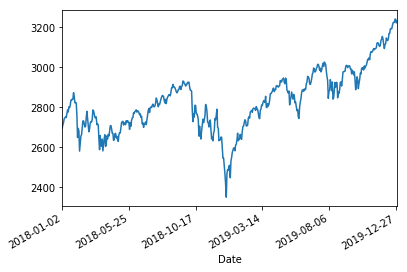

In [8]:
uni_data.plot(subplots=True)

In [9]:
uni_data = uni_data.values

In [10]:
#Standardize the data

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [11]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [12]:
#Create the data for univariate model. Step 1, the model will be given 20 observations, and needs to learn to predict the value for next step.

univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [13]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target value to predict')
print (y_train_uni[0])

Single window of past history
[[-0.42177268]
 [-0.24976901]
 [-0.14078418]
 [ 0.05026366]
 [ 0.09573304]
 [ 0.13143081]
 [ 0.10091827]
 [ 0.29366288]
 [ 0.47992472]
 [ 0.38200659]
 [ 0.64265584]
 [ 0.59748588]
 [ 0.71983304]
 [ 0.94587999]
 [ 1.00730187]
 [ 0.99144917]
 [ 1.00849958]
 [ 1.34373342]
 [ 1.150889  ]
 [ 0.84078286]]

 Target value to predict
0.8545444224471175


In [14]:
def create_time_steps(length):
  return list(range(-length, 0))

In [15]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/Users/eduardofontes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

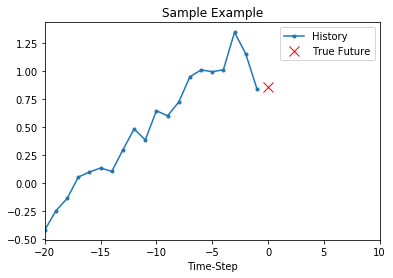

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [ ]:
#Baseline, this will be the average value from last 20 observations

def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/Users/eduardofontes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

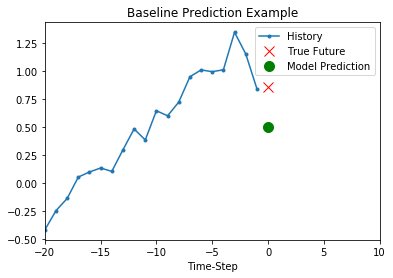

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [ ]:
#Time to run an RNN model:

BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


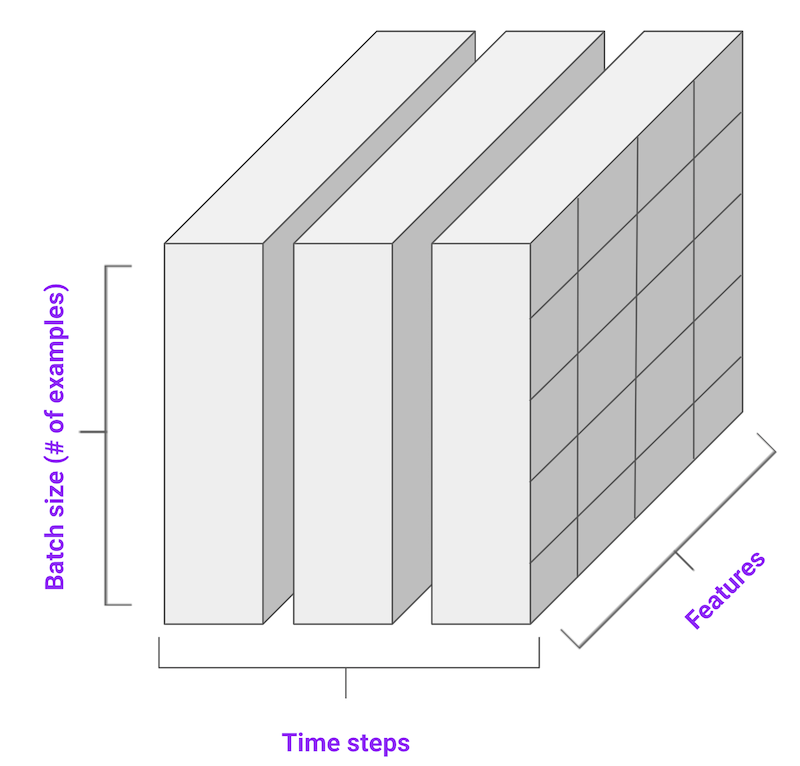

In [ ]:
from IPython.display import Image
Image(filename='ml/TSA/time_series RNN.png')

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
#for x, y in val_univariate.take(1):
#    print(simple_lstm_model.predict(x, steps=None).shape)

In [1]:
EVALUATION_INTERVAL = 5
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=20)

NameError: name 'simple_lstm_model' is not defined